In [1]:
import csv  #used for reading csv files
import inspect   #used when debug is set to True
import pandas as pd #used to create and manipulte dataframes
from typing import List, Dict
import numpy as np
import random
import math
from scipy.special import softmax
from queue import PriorityQueue
import itertools
import matplotlib.pyplot as plt
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [2]:
rooms = "ROOMS.csv"
courses = "COURSES.csv"
np.set_printoptions(precision=5)
average_fitness_dict = {}
pop_size = 500
number_of_generations = 500
parents_to_keep = 50

initial_mutation_chance = 0.1  # Initial mutation chance
percentage_decay = 0.5         # Decay percentage (50% in this example)
num_generations = 500          # Total number of generations
specific_num_generations = 50  # The number of generations after which the mutation chance should decay by the specified percentage
# Calculate the decay rate
decay_rate = (1 - percentage_decay) ** (1 / specific_num_generations)

In [3]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum()

In [4]:
def read_rooms(filename: str = rooms) -> pd.DataFrame:
    """
    Reads a csv file of the format:
    Room name, Capacity, Available Times
    The first line is a label line.
    
    Args:
        filename (str): the name of the file containing room information
        
    Returns:
        rooms_df (pd.DataFrame): A dataframe of the csv file
    """
    rooms_df = pd.read_csv(filename)
    rooms_df["AVAILABLE TIMES"] = rooms_df["AVAILABLE TIMES"].str.split(',')
    return rooms_df

In [5]:
def read_courses(filename: str = courses) -> pd.DataFrame:
    """
    Reads a csv file of the format
    Course name, expected enrollment, Preferred facilitator, Other Facilitators, Duration (Military convention)
    The first line is a label line.
    
    Args:
        filename (str): the name of the file containing room information.  
            filename set to rooms, a defined global variable, by default
        
    Returns:
        courses_df (pd.DataFrame): A dataframe of the csv file
    """
    courses_df = pd.read_csv(filename)
    courses_df["PREFERRED FACILITATORS"] = courses_df["PREFERRED FACILITATORS"].str.split(',')
    courses_df["OTHER FACILITATORS"] = courses_df["OTHER FACILITATORS"].str.split(',')
    return courses_df

In [6]:
def chromosome_generator(
    facilitators_list: List[str], 
    room_list: List[str], 
    time_list: List[str], 
    course_list: List[str]
) -> List[Dict[str, str]]:
    """Generate a chromosome for a course scheduling problem.

    Args:
        facilitators_list: A list of strings representing the available facilitators.
        room_list: A list of strings representing the available rooms.
        time_list: A list of strings representing the available time slots.
        course_list: A list of strings representing the courses to schedule.

    Returns:
        A list of dictionaries representing the chromosome, where each dictionary 
        corresponds to a gene and contains the following keys:
        - 'course': The name of the course.
        - 'time_slot': The time slot assigned to the course.
        - 'room': The room assigned to the course.
        - 'facilitator': The facilitator assigned to the course.

    Raises:
        ValueError: If any of the input lists is empty, or if there are not enough 
        time slots to schedule all courses, or if there are no available time slots, 
        rooms, or facilitators to schedule a course.

    """
    chromosome = []
    for course in course_list:
        gene = {
            'course': course, 
            'time_slot': random.choice(time_list),
            'room': random.choice(room_list),
            'facilitator': random.choice(facilitators_list)}
        chromosome.append(gene)
    return chromosome


In [7]:
def eval_room_fitness(rooms_df, courses_df, chromosome):
    fitness = 0
    for i in range(len(chromosome)-1):
        gene1 = chromosome[i]
        for j in range(i + 1, len(chromosome)):
            gene2 = chromosome[j]
            if gene1['time_slot'] == gene2['time_slot'] and gene1['room'] == gene2['room']:
                fitness += -0.5

        expected_enrollment = courses_df.loc[courses_df['COURSE'] == gene1['course'], 'EXPECTED ENROLLMENT'].values[0]
        room_capacity = rooms_df.loc[rooms_df['ROOM'] == gene1['room'], 'CAPACITY'].values[0]
        if expected_enrollment > room_capacity:
            fitness += -0.5
        elif expected_enrollment < room_capacity / 3:
            fitness += -0.2
            if expected_enrollment < room_capacity / 6:
                fitness += -0.2
        else:
            fitness += 0.3
    return fitness

def eval_preferred_facilitator(courses_df, chromosome):
    fitness = 0
    for gene in chromosome:
        preferred_facilitators = courses_df.loc[courses_df['COURSE'] == gene['course'], 'PREFERRED FACILITATORS'].values[0]
        other_facilitators = courses_df.loc[courses_df['COURSE'] == gene['course'], 'OTHER FACILITATORS'].values[0]
        if gene['facilitator'] in preferred_facilitators:
            fitness += 0.5
        elif gene['facilitator'] in other_facilitators:
            fitness += 0.2
        else:
            fitness += -0.1
    return fitness


def eval_facilitator_workload(facilitators_list, chromosome):
    fitness = 0
    activities_count = {facilitator: 0 for facilitator in facilitators_list}
    
    for gene in chromosome:
        activities_count[gene['facilitator']] += 1
    
    for facilitator, activities in activities_count.items():
        if activities == 0:
            continue
        if activities >= 4:
            fitness -= 0.5
        elif activities < 3 and facilitator != 'TYLER':
            fitness -= 0.4
    
    for i in range(len(chromosome) - 1):
        gene1 = chromosome[i]
        for j in range(i + 1, len(chromosome)):
            gene2 = chromosome[j]
            time_difference = abs(int(gene1['time_slot']) - int(gene2['time_slot']))
            same_facilitator = gene1['facilitator'] == gene2['facilitator']
            
            '''if time_difference == 200 and same_facilitator:
                fitness += 0.25
            elif time_difference == 100 and same_facilitator:
                fitness += 0.5'''

            room1_prefix = gene1['room'].split()[0]
            room2_prefix = gene2['room'].split()[0]
            if time_difference == 100:

                if (room1_prefix, room2_prefix) in (('ROMAN', 'BEACH'), ('BEACH', 'ROMAN')):
                        fitness -= 0.4
            
            if time_difference == 0 and same_facilitator:
                fitness -= 0.2

    return fitness



def eval_activities(chromosome):
    fitness = 0

    for i in range(len(chromosome) - 1):
        gene1 = chromosome[i]
        course1 = gene1['course']
        for j in range(i + 1, len(chromosome)):
            gene2 = chromosome[j]
            course2 = gene2['course']
            
            same_course_group = (
                (course1 in ('SLA101A', 'SLA101B') and course2 in ('SLA191A', 'SLA191B')) or
                (course1 in ('SLA191A', 'SLA191B') and course2 in ('SLA101A', 'SLA101B'))
            )
            same_course = (
                (course1 in ('SLA101A', 'SLA101B') and course2 in ('SLA101A', 'SLA101B')) or
                (course1 in ('SLA191A', 'SLA191B') and course2 in ('SLA191A', 'SLA191B'))
            )
            
            time_difference = abs(int(gene1['time_slot']) - int(gene2['time_slot']))
            
            if same_course_group:
                if time_difference == 0:
                    fitness -= 0.25
                elif time_difference == 100:
                    fitness += 0.5
                    if gene1['facilitator'] == gene2['facilitator']:
                        fitness += 0.5
                    room1_prefix = gene1['room'].split()[0]
                    room2_prefix = gene2['room'].split()[0]
                    if ((room1_prefix == 'ROMAN' and  room2_prefix == 'BEACH') or
                        (room1_prefix == 'BEACH' and  room2_prefix == 'ROMAN')):
                        fitness -= 0.4
                        if gene1['facilitator'] == gene2['facilitator']:
                            fitness += -0.4
                elif time_difference == 200:
                    fitness += 0.25
                    if gene1['facilitator'] == gene2['facilitator']:
                        fitness += 0.25
            elif same_course:
                if time_difference == 0:
                    fitness -= 0.5
                elif time_difference >= 400:
                    fitness += 0.5

    return fitness


def eval_fitness(
    rooms_df, 
    courses_df, 
    chromosome, 
    facilitators_list):
    fitness = 0
    fitness += eval_room_fitness(rooms_df, courses_df, chromosome)
    fitness += eval_preferred_facilitator(courses_df, chromosome)
    fitness += eval_facilitator_workload(facilitators_list, chromosome)
    fitness += eval_activities(chromosome)
    return fitness

In [8]:

async def generate_initial_population(rooms_df, courses_df, facilitators_list, room_list, time_list, course_list, pop_size):

    async def _generate_individual():
        chromosome = chromosome_generator(facilitators_list, room_list, time_list, course_list)
        fitness = eval_fitness(rooms_df, courses_df, chromosome, facilitators_list)

        individual = {
            'chromosome': chromosome,
            'fitness': fitness,
            'softmax': None
        }
        return individual

    tasks = [_generate_individual() for _ in range(pop_size)]
    population = await asyncio.gather(*tasks)

    # Calculate softmax scores and update the 'softmax' field in each individual
    fitness_scores = np.array([ind['fitness'] for ind in population])
    softmax_scores = softmax(fitness_scores)
    for i, individual in enumerate(population):
        individual['softmax'] = softmax_scores[i]

    # Sort the population by softmax score in descending order
    population.sort(key=lambda x: x['softmax'], reverse=True)

    return population


In [9]:
def breed_parents(parent1, parent2, mutation_chance, time_list, room_list, facilitators_list):
    child = []
    child_fitness = 0
    gene_element_list = ['time_slot', 'room', 'facilitator']
    for gene1, gene2 in zip(parent1['chromosome'], parent2['chromosome']):
        new_gene = {}
        new_gene['course'] = gene1['course']
        for element in gene_element_list:
            is_mutated = mutation_chance > random.random()
            if is_mutated:
                if element == 'time_slot':
                    new_gene[element] = random.choice(time_list)
                elif element == 'room': 
                    new_gene[element] = random.choice(room_list)
                else:
                    new_gene[element] = random.choice(facilitators_list)
            else:
                which_parent = random.randint(0, 1)
                if which_parent == 0:
                    new_gene[element] = gene1[element]
                else:
                    new_gene[element] = gene2[element]
        child.append(new_gene)
    
    fitness = eval_fitness(
        rooms_df, 
        courses_df, 
        child, 
        facilitators_list
    )
    return child, fitness



In [10]:
def roulette_wheel_selection(
    previous_generation
):
    probabilities = np.array([item['softmax'] for item in previous_generation])
    probabilities /= probabilities.sum()
    selected_index = np.random.choice(len(previous_generation), p=probabilities)
    return previous_generation[selected_index]

In [11]:
async def generate_next_generation(previous_generation, facilitators_list, room_list, time_list, pop_size, parents_to_keep, mutation_chance):

    async def _generate_child(parents):
        parent1, parent2 = parents
        child, child_fitness = breed_parents(
            parent1,
            parent2,
            mutation_chance,
            time_list,
            room_list,
            facilitators_list
        )
        return {
            'chromosome': child,
            'fitness': child_fitness,
            'softmax': None
        }

    survivors = previous_generation[:parents_to_keep]

    tasks = []
    for _ in range(pop_size - parents_to_keep):
        parents = (roulette_wheel_selection(previous_generation), roulette_wheel_selection(previous_generation))
        task = asyncio.create_task(_generate_child(parents))
        tasks.append(task)

    children = await asyncio.gather(*tasks)

    # Calculate softmax scores and update the 'softmax' field in each child
    fitness_scores = np.array([ind['fitness'] for ind in children])
    softmax_scores = softmax(fitness_scores)
    for i, child_individual in enumerate(children):
        child_individual['softmax'] = softmax_scores[i]

    # Combine parents and children, and sort the population by softmax score in descending order
    next_generation = survivors + children
    next_generation.sort(key=lambda x: x['softmax'], reverse=True)

    return next_generation


In [12]:
def calc_avg_generation_fitness(
    generation
):
    fitness_values = [element['fitness'] for element in generation]
    return np.mean(fitness_values)

In [13]:
def setup():
    rooms_df = read_rooms()
    courses_df = read_courses()
    preferred_list = np.unique(courses_df['PREFERRED FACILITATORS'])
    other_list = np.unique(courses_df['OTHER FACILITATORS'])
    temp_list = np.unique(np.concatenate((preferred_list, other_list)))
    facilitators_list = []
    for item in temp_list:
        for element in item:
            facilitators_list.append(element.strip())
    facilitators_list = list(set(facilitators_list))
    room_list = np.unique(rooms_df['ROOM'])
    time_list = np.unique(rooms_df["AVAILABLE TIMES"])[0]

    course_list = np.unique(courses_df["COURSE"])
    return rooms_df, courses_df, preferred_list, other_list, facilitators_list, room_list, time_list, course_list

In [14]:

async def evolve_async(current_generation, facilitators_list, room_list, time_list, pop_size, parents_to_keep, current_mutation_chance, decay_rate, number_of_generations):

    gen_numbers = []
    avg_fitnesses = []
    mutation_chances = []

    for i in range(1, number_of_generations + 1):
        next_generation = await generate_next_generation(
            current_generation,
            facilitators_list,
            room_list,
            time_list,
            pop_size,
            parents_to_keep,
            current_mutation_chance
        )

        gen_fitness = calc_avg_generation_fitness(next_generation)
        print(f"Generation {i}: Average fitness = {gen_fitness:.2f}")

        gen_numbers.append(i)
        avg_fitnesses.append(gen_fitness)
        mutation_chances.append(current_mutation_chance)

        current_mutation_chance = initial_mutation_chance * (decay_rate ** (i - 1))
        current_generation = next_generation

    return current_generation, gen_numbers, avg_fitnesses, mutation_chances

Generation 1: Average fitness = -0.61
Generation 2: Average fitness = 0.42
Generation 3: Average fitness = 1.10
Generation 4: Average fitness = 1.52
Generation 5: Average fitness = 2.13
Generation 6: Average fitness = 2.56
Generation 7: Average fitness = 2.87
Generation 8: Average fitness = 3.07
Generation 9: Average fitness = 3.44
Generation 10: Average fitness = 3.76
Generation 11: Average fitness = 4.17
Generation 12: Average fitness = 4.76
Generation 13: Average fitness = 5.04
Generation 14: Average fitness = 5.35
Generation 15: Average fitness = 5.57
Generation 16: Average fitness = 5.53
Generation 17: Average fitness = 5.53
Generation 18: Average fitness = 5.70
Generation 19: Average fitness = 5.70
Generation 20: Average fitness = 5.88
Generation 21: Average fitness = 5.93
Generation 22: Average fitness = 5.96
Generation 23: Average fitness = 5.96
Generation 24: Average fitness = 5.86
Generation 25: Average fitness = 5.81
Generation 26: Average fitness = 6.05
Generation 27: Avera

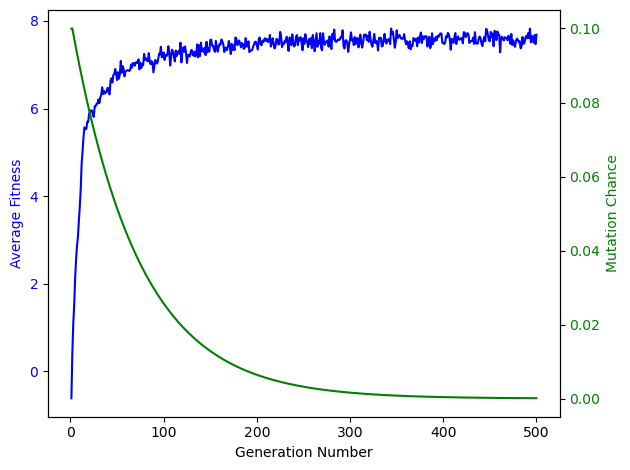

In [15]:
rooms_df, courses_df, preferred_list, other_list, facilitators_list, room_list, time_list, course_list = setup()

async def main(rooms_df, courses_df, preferred_list, other_list, facilitators_list, room_list, time_list, course_list):
    initial_population = await generate_initial_population(
        rooms_df,
        courses_df,
        facilitators_list,
        room_list,
        time_list,
        course_list,
        pop_size
    )
    current_generation = initial_population
    current_mutation_chance = initial_mutation_chance

    current_generation, gen_numbers, avg_fitnesses, mutation_chances = await evolve_async(
        current_generation,
        facilitators_list,
        room_list,
        time_list,
        pop_size,
        parents_to_keep,
        current_mutation_chance,
        decay_rate,
        number_of_generations
    )

    return current_generation, gen_numbers, avg_fitnesses, mutation_chances

loop = asyncio.get_event_loop()
current_generation, gen_numbers, avg_fitnesses, mutation_chances = loop.run_until_complete(
    main(
        rooms_df, 
        courses_df, 
        preferred_list, 
        other_list, 
        facilitators_list, 
        room_list, 
        time_list, 
        course_list
    )
)

fig, ax1 = plt.subplots()

ax1.plot(gen_numbers, avg_fitnesses, label='Average Fitness', color='blue')
ax1.set_xlabel('Generation Number')
ax1.set_ylabel('Average Fitness', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(gen_numbers, mutation_chances, label='Mutation Chance', color='green')
ax2.set_ylabel('Mutation Chance', color='green')
ax2.tick_params(axis='y', labelcolor='green')

fig.tight_layout()
plt.show()

In [18]:
table = pd.DataFrame(current_generation[0]['chromosome'])

# Convert the 'time_slot' column to integer type for proper sorting
table['time_slot'] = table['time_slot'].str.strip().astype(int)

# Sort the DataFrame by 'time_slot'
table = table.sort_values(by='time_slot')

# Reset the index after sorting
table = table.reset_index(drop=True)

# Display the sorted DataFrame as a table
print(table)
table.to_csv('final_schedule.csv')

     course  time_slot        room facilitator
0   SLA101B       1000   BEACH 301        GLEN
1    SLA449       1000    LOFT 310       TYLER
2   SLA191B       1100   FRANK 119        GLEN
3    SLA291       1100   BEACH 301        LOCK
4    SLA451       1100  SLATER 003       TYLER
5   SLA191A       1300   BEACH 201        GLEN
6    SLA304       1300  SLATER 003        GLEN
7    SLA201       1400    LOFT 206        GLEN
8   SLA101A       1500   BEACH 301        LOCK
9    SLA303       1500   BEACH 201        GLEN
10   SLA394       1500   FRANK 119       TYLER


In [17]:
current_generation[0]


{'chromosome': [{'course': 'SLA101A',
   'time_slot': ' 1500',
   'room': 'BEACH 301',
   'facilitator': 'LOCK'},
  {'course': 'SLA101B',
   'time_slot': '1000',
   'room': 'BEACH 301',
   'facilitator': 'GLEN'},
  {'course': 'SLA191A',
   'time_slot': ' 1300',
   'room': 'BEACH 201',
   'facilitator': 'GLEN'},
  {'course': 'SLA191B',
   'time_slot': ' 1100',
   'room': 'FRANK 119',
   'facilitator': 'GLEN'},
  {'course': 'SLA201',
   'time_slot': ' 1400',
   'room': 'LOFT 206',
   'facilitator': 'GLEN'},
  {'course': 'SLA291',
   'time_slot': ' 1100',
   'room': 'BEACH 301',
   'facilitator': 'LOCK'},
  {'course': 'SLA303',
   'time_slot': ' 1500',
   'room': 'BEACH 201',
   'facilitator': 'GLEN'},
  {'course': 'SLA304',
   'time_slot': ' 1300',
   'room': 'SLATER 003',
   'facilitator': 'GLEN'},
  {'course': 'SLA394',
   'time_slot': ' 1500',
   'room': 'FRANK 119',
   'facilitator': 'TYLER'},
  {'course': 'SLA449',
   'time_slot': '1000',
   'room': 'LOFT 310',
   'facilitator': 'TY